In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3,4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 256
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel/(2**int((i+1)/4))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 256)        1024      
_________________________________________________________________
activation (Activation)      (None, 16000, 256)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 4096000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 256)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 256)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0185 - acc: 0.3787
Epoch 00001: val_loss improved from inf to 1.47871, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_6_conv_checkpoint/001-1.4787.hdf5
36805/36805 [==============================] - 429s 12ms/sample - loss: 2.0184 - acc: 0.3787 - val_loss: 1.4787 - val_acc: 0.5113
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2026 - acc: 0.6201
Epoch 00002: val_loss improved from 1.47871 to 0.87692, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_6_conv_checkpoint/002-0.8769.hdf5
36805/36805 [==============================] - 423s 12ms/sample - loss: 1.2026 - acc: 0.6201 - val_loss: 0.8769 - val_acc: 0.7414
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9513 - acc: 0.7063
Epoch 00003: val_loss did not improve from 0.87692
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2095 - acc: 0.9349
Epoch 00025: val_loss did not improve from 0.38546
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.2095 - acc: 0.9348 - val_loss: 0.4056 - val_acc: 0.8991
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1942 - acc: 0.9391
Epoch 00026: val_loss improved from 0.38546 to 0.37648, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_6_conv_checkpoint/026-0.3765.hdf5
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.1941 - acc: 0.9391 - val_loss: 0.3765 - val_acc: 0.9038
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1822 - acc: 0.9419
Epoch 00027: val_loss did not improve from 0.37648
36805/36805 [==============================] - 425s 12ms/sample - loss: 0.1822 - acc: 0.9419 - val_loss: 0.4525 - val_acc: 0.8824
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1710 - 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9780
Epoch 00054: val_loss did not improve from 0.35123
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0714 - acc: 0.9780 - val_loss: 0.4740 - val_acc: 0.8905
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9732
Epoch 00055: val_loss did not improve from 0.35123
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0849 - acc: 0.9731 - val_loss: 0.4843 - val_acc: 0.8901
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9769
Epoch 00056: val_loss did not improve from 0.35123
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0729 - acc: 0.9769 - val_loss: 0.3952 - val_acc: 0.9143
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0595 - acc: 0.9817
Epoch 00057: val_loss did not improve from 0.35123
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9887
Epoch 00083: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0375 - acc: 0.9887 - val_loss: 0.4403 - val_acc: 0.9106
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9869
Epoch 00084: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0442 - acc: 0.9869 - val_loss: 0.5246 - val_acc: 0.8980
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0411 - acc: 0.9877
Epoch 00085: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0412 - acc: 0.9876 - val_loss: 0.4875 - val_acc: 0.8982
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9854
Epoch 00086: val_loss did not improve from 0.33555
36805/36805 [=====

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9900
Epoch 00113: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0347 - acc: 0.9900 - val_loss: 0.6407 - val_acc: 0.8772
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9915
Epoch 00114: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0288 - acc: 0.9915 - val_loss: 0.5012 - val_acc: 0.8980
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9917
Epoch 00115: val_loss did not improve from 0.33555
36805/36805 [==============================] - 426s 12ms/sample - loss: 0.0270 - acc: 0.9917 - val_loss: 0.5213 - val_acc: 0.9061
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9920
Epoch 00116: val_loss did not improve from 0.33555
36805/36805 [=

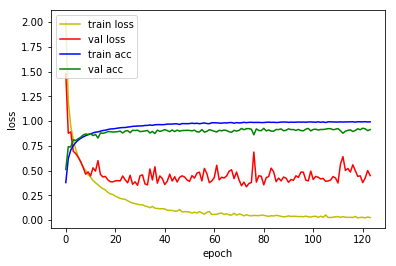

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.4405 - acc: 0.8999
Loss: 0.4404968751553806 Accuracy: 0.89989614

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1318 - acc: 0.3443
Epoch 00001: val_loss improved from inf to 1.76927, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_7_conv_checkpoint/001-1.7693.hdf5
36805/36805 [==============================] - 432s 12ms/sample - loss: 2.1320 - acc: 0.3443 - val_loss: 1.7693 - val_acc: 0.3818
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2394 - acc: 0.6033
Epoch 00002: val_loss improved from 1.76927 to 0.81950, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_7_conv_checkpoint/002-0.8195.hdf5
36805/36805 [==============================] - 427s 12ms/sample - loss: 1.2394 - acc: 0.6033 - val_loss: 0.8195 - val_acc: 0.7645
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9891
Epoch 00054: val_loss did not improve from 0.19807
36805/36805 [==============================] - 427s 12ms/sample - loss: 0.0362 - acc: 0.9891 - val_loss: 0.3126 - val_acc: 0.9322
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9860
Epoch 00055: val_loss did not improve from 0.19807
36805/36805 [==============================] - 427s 12ms/sample - loss: 0.0444 - acc: 0.9860 - val_loss: 0.2250 - val_acc: 0.9464
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9885
Epoch 00056: val_loss did not improve from 0.19807
36805/36805 [==============================] - 427s 12ms/sample - loss: 0.0389 - acc: 0.9885 - val_loss: 0.2570 - val_acc: 0.9434
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9882
Epoch 00057: val_loss did not improve from 0.19807
36805/36805 [==================

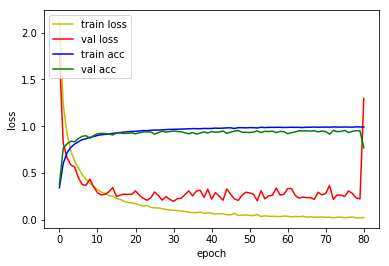

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2741 - acc: 0.9279
Loss: 0.2740789396883697 Accuracy: 0.9279335

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1919 - acc: 0.3376
Epoch 00001: val_loss improved from inf to 1.45830, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_8_conv_checkpoint/001-1.4583.hdf5
36805/36805 [==============================] - 436s 12ms/sample - loss: 2.1918 - acc: 0.3376 - val_loss: 1.4583 - val_acc: 0.5723
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1713 - acc: 0.6261
Epoch 00002: val_loss improved from 1.45830 to 0.74672, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_8_conv_checkpoint/002-0.7467.hdf5
36805/36805 [==============================] - 428s 12ms/sample - loss: 1.1712 - acc: 0.6261 - val_loss: 0.7467 - val_acc: 0.7848
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0934 - acc: 0.9709
Epoch 00026: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0934 - acc: 0.9708 - val_loss: 0.1472 - val_acc: 0.9560
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.9764
Epoch 00027: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0782 - acc: 0.9764 - val_loss: 0.1549 - val_acc: 0.9553
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0676 - acc: 0.9793
Epoch 00028: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0677 - acc: 0.9792 - val_loss: 0.1400 - val_acc: 0.9630
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9746
Epoch 00029: val_loss did not improve from 0.12493
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9913
Epoch 00056: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0287 - acc: 0.9913 - val_loss: 0.1466 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9941
Epoch 00057: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0199 - acc: 0.9941 - val_loss: 0.1655 - val_acc: 0.9620
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9941
Epoch 00058: val_loss did not improve from 0.12493
36805/36805 [==============================] - 428s 12ms/sample - loss: 0.0201 - acc: 0.9941 - val_loss: 0.2087 - val_acc: 0.9548
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9942
Epoch 00059: val_loss did not improve from 0.12493
36805/36805 [=====

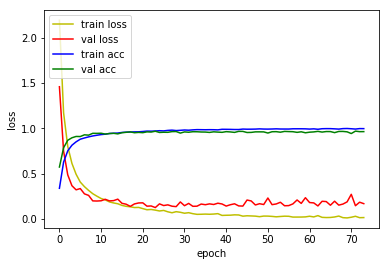

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.1530 - acc: 0.9566
Loss: 0.15303098773458046 Accuracy: 0.956594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0073 - acc: 0.3897
Epoch 00001: val_loss improved from inf to 1.37891, saving model to model/checkpoint/1D_CNN_custom_4_DO_BN_9_conv_checkpoint/001-1.3789.hdf5
36805/36805 [==============================] - 441s 12ms/sample - loss: 2.0074 - acc: 0.3897 - val_loss: 1.3789 - val_acc: 0.6161
Epoch 2/500
 5056/36805 [===>..........................] - ETA: 5:56 - loss: 1.2059 - acc: 0.6224

ResourceExhaustedError: OOM when allocating tensor with shape[64,256,16000,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_12/Adam/gradients/max_pooling1d_54/MaxPool_grad/MaxPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [10]:
for i in range(6, 10):
    base = '1D_CNN_custom_2_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
    #         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_2_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(6, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')

In [ ]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(6, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')